# Importing Libraries

In [ ]:
# Standard Library
import os

# Data Science Libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt

# Machine Learning Libraries (Scikit-learn)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 3. Loading the Data into a Pandas DataFrame

Code Block 3A

In [ ]:
# Define the path to the CSV file containing air quality data
csv_path = '/content/drive/MyDrive/Air Quality Prediction/aqidaily_fiveyears.csv'

# Read the CSV file into a DataFrame using pandas
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame to check the data
df.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
0,1/1/2023,46,PM2.5,Long Beach-Route 710 Near Road,06-037-4008,AQS,13.0,38.0,36.0,106.0,30.0
1,1/2/2023,56,PM2.5,Compton,06-037-1302,AQS,14.0,40.0,18.0,56.0,37.0
2,1/3/2023,42,PM2.5,Reseda,06-037-1201,AQS,15.0,34.0,35.0,66.0,50.0
3,1/4/2023,38,Ozone,Santa Clarita,06-037-6012,AQS,16.0,38.0,37.0,75.0,58.0
4,1/5/2023,46,PM2.5,Long Beach-Route 710 Near Road,06-037-4008,AQS,22.0,36.0,50.0,95.0,60.0


# 4. Preprocessing

Code Block 4A

In [ ]:
# Convert the 'Date' column to datetime format and set it as the DataFrame index
df.index = pd.to_datetime(df['Date'])

# Display the first 5 rows of the updated DataFrame to verify the changes
df.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,,
2023-01-01,1/1/2023,46,PM2.5,Long Beach-Route 710 Near Road,06-037-4008,AQS,13.0,38.0,36.0,106.0,30.0
2023-01-02,1/2/2023,56,PM2.5,Compton,06-037-1302,AQS,14.0,40.0,18.0,56.0,37.0
2023-01-03,1/3/2023,42,PM2.5,Reseda,06-037-1201,AQS,15.0,34.0,35.0,66.0,50.0
2023-01-04,1/4/2023,38,Ozone,Santa Clarita,06-037-6012,AQS,16.0,38.0,37.0,75.0,58.0
2023-01-05,1/5/2023,46,PM2.5,Long Beach-Route 710 Near Road,06-037-4008,AQS,22.0,36.0,50.0,95.0,60.0


Code Block 4B

<Axes: xlabel='Date'>

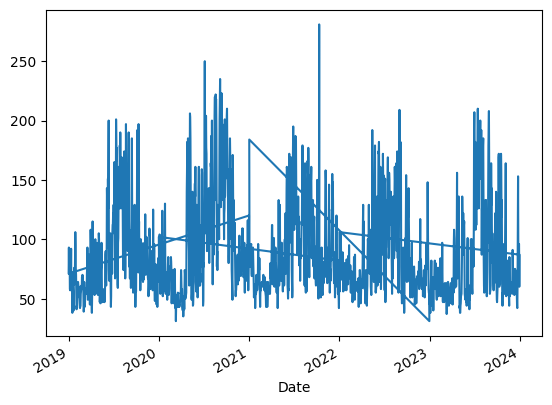

In [ ]:
# Extract the 'Overall AQI Value' column from the DataFrame and store it in a variable 'temp'
temp = df['Overall AQI Value']

# Plot the values in the 'temp' series to visualize the trend of the AQI over time
temp.plot()

Code Block 4C

In [ ]:
# Drop the unnecessary columns
df.drop(columns=['Site Name (of Overall AQI)'], inplace=True)

df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2023-01-01,1/1/2023,46,PM2.5,06-037-4008,AQS,13.0,38.0,36.0,106.0,30.0
2023-01-02,1/2/2023,56,PM2.5,06-037-1302,AQS,14.0,40.0,18.0,56.0,37.0
2023-01-03,1/3/2023,42,PM2.5,06-037-1201,AQS,15.0,34.0,35.0,66.0,50.0
2023-01-04,1/4/2023,38,Ozone,06-037-6012,AQS,16.0,38.0,37.0,75.0,58.0
2023-01-05,1/5/2023,46,PM2.5,06-037-4008,AQS,22.0,36.0,50.0,95.0,60.0


Code Block 4D

In [ ]:
# Convert columns to numeric, coercing errors to NaN
df['CO'] = pd.to_numeric(df['CO'], errors='coerce')
df['Ozone'] = pd.to_numeric(df['Ozone'], errors='coerce')
df['PM10'] = pd.to_numeric(df['PM10'], errors='coerce')
df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')

# Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Fill Null values (if any) with last known number
df.ffill(inplace=True)

df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2023-01-01,1/1/2023,46,PM2.5,06-037-4008,AQS,13.0,38.0,36.0,106.0,30.0
2023-01-02,1/2/2023,56,PM2.5,06-037-1302,AQS,14.0,40.0,18.0,56.0,37.0
2023-01-03,1/3/2023,42,PM2.5,06-037-1201,AQS,15.0,34.0,35.0,66.0,50.0
2023-01-04,1/4/2023,38,Ozone,06-037-6012,AQS,16.0,38.0,37.0,75.0,58.0
2023-01-05,1/5/2023,46,PM2.5,06-037-4008,AQS,22.0,36.0,50.0,95.0,60.0


Code Block 4E

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# TODO: Select the columns to normalize
columns_to_normalize = ['CO', 'Ozone', 'PM10', 'PM25', 'NO2']

# Fit and transform the data
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,Date,Overall AQI Value,Main Pollutant,Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
Date,,,,,,,,,,
2023-01-01,1/1/2023,46,PM2.5,06-037-4008,AQS,0.256410,0.070755,0.121864,0.348416,0.239130
2023-01-02,1/2/2023,56,PM2.5,06-037-1302,AQS,0.282051,0.080189,0.057348,0.122172,0.315217
2023-01-03,1/3/2023,42,PM2.5,06-037-1201,AQS,0.307692,0.051887,0.118280,0.167421,0.456522
2023-01-04,1/4/2023,38,Ozone,06-037-6012,AQS,0.333333,0.070755,0.125448,0.208145,0.543478
2023-01-05,1/5/2023,46,PM2.5,06-037-4008,AQS,0.487179,0.061321,0.172043,0.298643,0.565217


Code Block 4F

In [ ]:
def df_to_X_y(df, window_size=5):
    # Convert the input dataframe to a NumPy array for easier manipulation
    df_as_np = df.to_numpy()

    # Initialize empty lists to hold the features (X), labels (y), and indices
    X = []
    y = []
    indices = []

    # Iterate over the length of the dataframe minus the window size
    for i in range(len(df_as_np) - window_size):
        # Extract a 'window' of values from the dataframe (a slice of rows)
        # and format each value as a list (to keep consistent dimensionality)
        row = [[a] for a in df_as_np[i:i + window_size]]

        # Append the windowed rows to the feature list X
        X.append(row)

        # The label (y) is the value that follows the current window
        label = df_as_np[i + window_size]

        # Append the label to the label list y
        y.append(label)

        # Append the starting index of the window to the indices list
        indices.append(df.index[i])

    # Convert the feature (X) and label (y) lists into NumPy arrays and return them along with the indices
    return np.array(X), np.array(y), np.array(indices)

Code Block 4G

In [ ]:
# TODO: Change the window size to reflect how many days in advance we want to predict AQI
WINDOW_SIZE = 365  # Define the size of the sliding window (number of time steps to consider for each sequence)

# X will contain sequences of length 'WINDOW_SIZE', and y will contain the corresponding labels (next values)
X, y, indices = df_to_X_y(temp, WINDOW_SIZE)

# Output the shapes of X and y to check the dimensions
X.shape, y.shape

((1461, 365, 1), (1461,))

## 5. Split to Train, Validation, and Test

Code Block 5A

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X, y, and indices are already defined
indices = np.arange(len(X))  # Create an array of indices (or use the actual indices if available)

# Step 1: Split the dataset into training+validation and test sets, preserving indices
X_train_val, X_test, y_train_val, y_test, indices_train_val, indices_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=123
)

# Step 2: Split the training+validation set into training and validation sets, preserving indices
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train_val, y_train_val, indices_train_val, test_size=0.25, random_state=123
)


indices_test

# Now you have the features (X), labels (y), and corresponding indices for each split.

array([ 147,  676, 1240, 1373, 1249, 1127,   35,  954, 1297,  613,   18,
        602, 1298,  734,  316,   28, 1048,  167,  756, 1067, 1260, 1294,
        156, 1215, 1411,   36,  476, 1438,  512,  772,   31,  973,  946,
        103, 1229,  933,  356,  185,  919,   61,   42, 1126,  171, 1194,
        421,   76,  196, 1057,  737,  814,  800, 1042,  674, 1287,  307,
        627,   12,  668,  169,  309,  553,  642, 1267,  466,  131,  840,
       1269,   13,  824, 1209,  779,  666, 1173,  468,  104,  969,  616,
        550,  444,  543,  610,  332,  976,  985, 1191,  502,  210, 1446,
       1166,  706, 1256,  433,  882,  735,  188,  448,  939,  870, 1199,
        847, 1186,  803,  320,  611,  256,  406, 1094,  351, 1359, 1115,
        408,  934,   48, 1087,  689, 1214,  780,  161,  450,  831, 1372,
        319, 1056, 1412,  189,  866,  586,  617,  914,  524, 1179,  644,
        692,  266,  218,  260, 1058,  437,  348,  697,  431,  297,  384,
        777, 1162,  249,  302,  767,  429, 1140,  5

Code Block 5B

In [ ]:
# Now, you have:
# X_train, y_train: Training set (60%)
# X_val, y_val: Validation set (20%)
# X_test, y_test: Test set (20%)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (876, 365, 1)
y_train shape: (876,)
X_val shape: (292, 365, 1)
y_val shape: (292,)
X_test shape: (293, 365, 1)
y_test shape: (293,)


# 6. Training the Model

Code Block 6A

In [ ]:
# Predict the labels of the test set
## Set max_depth to be 10 instead of 100
# Instatiate a XGBRegressor instead of XGBClassifier
xgb_reg = xgb.XGBRegressor(random_state=123)

# Inspect the parameters
xgb_reg.get_params()

## Set max_depth to be 10 instead of 100
xgb_reg.set_params(n_estimators=10)

# Reshape X_train and X_test to 2D before fitting and predicting
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to (n_samples, n_features)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)    # Reshape to (n_samples, n_features)


# Fit it to the training set
xgb_reg.fit(X_train_reshaped, y_train)

# Predict the labels of the test set
y_pred = xgb_reg.predict(X_test_reshaped)

y_test

array([ 55,  93,  58, 164,  67,  52,  62, 147, 101, 154,  77, 159, 126,
       103,  64,  57,  81,  80,  83, 109,  65,  62,  90,  53, 102,  86,
        55, 125, 122,  58,  79, 115, 122,  67,  97, 100, 102, 151, 105,
        74,  70,  70, 112, 101,  66,  67, 169,  87,  64,  44,  41,  57,
       158, 136,  55, 115,  81,  81,  71,  66, 179,  71,  43,  71,  77,
        53,  97,  89,  58,  93,  85,  63,  65,  63,  56, 129, 161, 180,
        55, 195, 150,  67, 201, 189,  51,  74, 108,  54,  56,  78, 126,
        43,  71,  75,  93,  55, 129,  54,  90, 108,  97,  45,  65, 136,
        58,  84,  79,  80, 126,  54,  55,  80,  61,  95,  82,  56,  81,
       154,  62,  52, 100,  73, 103, 101,  93, 140, 143, 115, 129,  58,
        87,  58,  64,  93, 136,  55,  77,  57,  78,  86,  54,  59,  51,
        75,  46, 156,  77,  79,  60,  51, 119,  64,  83, 100,  45,  59,
       136,  97,  75, 100,  71,  55,  97,  57, 133,  73,  74,  65, 120,
        53, 105,  64,  63,  72,  97, 166, 156, 122,  84,  77, 11

Code Block 6B

Code Block 6C

# 7. Evaluating the Model

Code Block 7A

Code Block 7B

In [ ]:
# Set the starting date
# start_date = pd.to_datetime('2019-01-01')
start_date = pd.to_datetime(df.index.min())

# Create a date range that covers the maximum index
max_index = indices_test.max()
date_range = pd.date_range(start=start_date, periods=max_index + 1)

# Use the indices to select corresponding dates from the date range
date_index = date_range[indices_test]

# Example data
data = {'Date': date_index, 'y_test': y_test, 'y_pred': y_pred}
df = pd.DataFrame(data)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort the DataFrame by the index (Date) in ascending order
df.sort_index(ascending=True, inplace=True)

# View the sorted DataFrame
df

,y_test,y_pred
Date,,
2019-01-13,81,71.523331
2019-01-14,89,77.271881
2019-01-19,77,73.678200
2019-01-29,57,80.812912
2019-02-01,79,71.706039
...,...,...
2022-11-21,55,60.028694
2022-11-30,79,78.528511
2022-12-09,125,58.745914


Code Block 7C

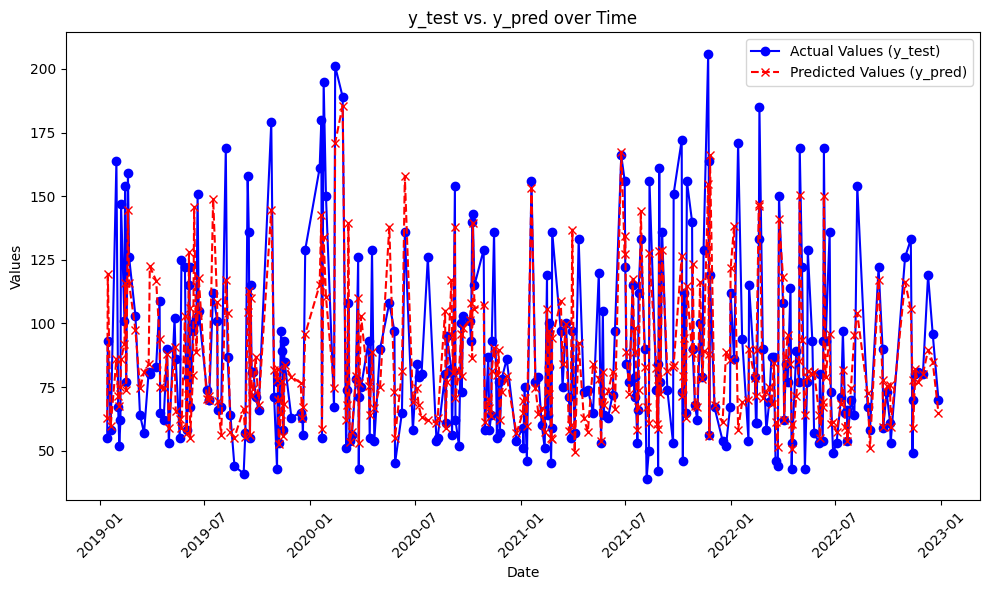

In [ ]:
# Plot the values against the date index
plt.figure(figsize=(10, 6))

# Get the dates corresponding to the test set
# The original line was: test_dates = df.index[indices_test]
# This caused an error because indices_test contained indices outside the range of df.index
# Instead, use the index of the df directly:
test_dates = df.index

# Plot y_test
plt.plot(test_dates, y_test, label='Actual Values (y_test)', color='blue', marker='o')

# Plot y_pred
plt.plot(test_dates, y_pred, label='Predicted Values (y_pred)', color='red', linestyle='--', marker='x')

# Customize the plot
plt.title('y_test vs. y_pred over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Code Block 7D

In [ ]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 16.952537536621094


Code Block 7E

In [ ]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 555.1268310546875


Code Block 7F

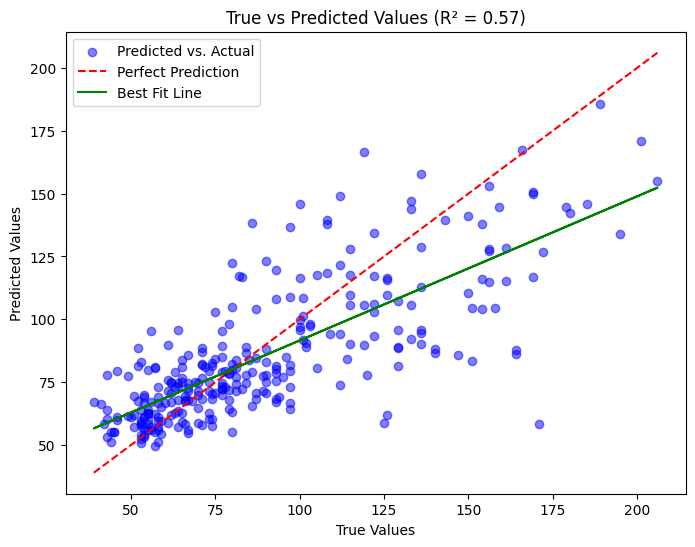

In [ ]:
# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Fit a best-fit line
model = LinearRegression()
y_test_reshaped = np.array(y_test).reshape(-1, 1)  # Reshape for fitting
model.fit(y_test_reshaped, y_pred)
y_best_fit = model.predict(y_test_reshaped)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction")
plt.plot(y_test, y_best_fit, color='green', linestyle='-', label="Best Fit Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs Predicted Values (R² = {r2:.2f})")
plt.legend()
plt.show()